# Cardiovascular Risk Prediction Model

Comparative Analysis of Supervised Learning Models

This notebook is part of the Health Companion - B.Tech CSE Major Project.

## Objective
To improve cardiovascular disease prediction by comparing multiple supervised learning algorithms and selecting the best-performing model for reliable risk screening.


## 1. Import Required Libraries


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt
import joblib
import json
from datetime import datetime


## 2. Load Dataset


In [2]:
from pathlib import Path

cwd = Path.cwd()
if cwd.name == 'notebooks':
    base_dir = cwd.parent
elif (cwd / 'health-models').exists():
    base_dir = cwd / 'health-models'
else:
    base_dir = cwd

data_dir = base_dir / 'data'
models_dir = base_dir / 'models'
reports_dir = base_dir / 'reports'
models_dir.mkdir(parents=True, exist_ok=True)
reports_dir.mkdir(parents=True, exist_ok=True)

data = pd.read_csv(data_dir / 'cardio.csv')

X = data.drop('CARDIO_DISEASE', axis=1)
y = data['CARDIO_DISEASE']

print('Dataset Shape:', data.shape)
print('Target Distribution:')
print(y.value_counts())


Dataset Shape: (120000, 12)
Target Distribution:
CARDIO_DISEASE
1    78759
0    41241
Name: count, dtype: int64


## 3. Class Imbalance Analysis


In [3]:
(y.value_counts(normalize=True) * 100).round(2)


CARDIO_DISEASE
1    65.63
0    34.37
Name: proportion, dtype: float64

## 4. Train-Test Split


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape


((96000, 11), (24000, 11))

## 5. Feature Scaling


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 6. Model Evaluation Function


In [6]:
def evaluate_model(model, X_tr, X_te):
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)

    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }


## 7. Train & Compare Supervised Models


In [7]:
results = {}

results['Logistic Regression'] = evaluate_model(
    LogisticRegression(max_iter=1000, random_state=42),
    X_train_scaled, X_test_scaled
)

results['Decision Tree'] = evaluate_model(
    DecisionTreeClassifier(random_state=42),
    X_train, X_test
)

results['Random Forest'] = evaluate_model(
    RandomForestClassifier(n_estimators=200, random_state=42),
    X_train, X_test
)

results['SVM'] = evaluate_model(
    SVC(kernel='rbf', probability=True, random_state=42),
    X_train_scaled, X_test_scaled
)

results['KNN'] = evaluate_model(
    KNeighborsClassifier(n_neighbors=5),
    X_train_scaled, X_test_scaled
)

results['Naive Bayes'] = evaluate_model(
    GaussianNB(),
    X_train, X_test
)

results


{'Logistic Regression': {'Accuracy': 0.687875,
  'Precision': 0.709808503073094,
  'Recall': 0.8871254443880142,
  'F1-Score': 0.7886227038008973,
  'Confusion Matrix': array([[ 2535,  5713],
         [ 1778, 13974]])},
 'Decision Tree': {'Accuracy': 0.5874583333333333,
  'Precision': 0.6897088385967187,
  'Recall': 0.6752158456069071,
  'F1-Score': 0.682385397619735,
  'Confusion Matrix': array([[ 3463,  4785],
         [ 5116, 10636]])},
 'Random Forest': {'Accuracy': 0.6713333333333333,
  'Precision': 0.7057561486132915,
  'Recall': 0.8562087353986796,
  'F1-Score': 0.7737364465607252,
  'Confusion Matrix': array([[ 2625,  5623],
         [ 2265, 13487]])},
 'SVM': {'Accuracy': 0.6856666666666666,
  'Precision': 0.6939325205557131,
  'Recall': 0.9322625698324022,
  'F1-Score': 0.7956330931353958,
  'Confusion Matrix': array([[ 1771,  6477],
         [ 1067, 14685]])},
 'KNN': {'Accuracy': 0.634375,
  'Precision': 0.6981314250014199,
  'Recall': 0.7803453529710513,
  'F1-Score': 0.73

## 8. Performance Comparison Table


In [8]:
metrics_df = pd.DataFrame({
    model: {
        'Accuracy': results[model]['Accuracy'],
        'Precision': results[model]['Precision'],
        'Recall': results[model]['Recall'],
        'F1-Score': results[model]['F1-Score']
    }
    for model in results
}).T

metrics_df.sort_values(by='F1-Score', ascending=False)


,Accuracy,Precision,Recall,F1-Score
SVM,0.685667,0.693933,0.932263,0.795633
Logistic Regression,0.687875,0.709809,0.887125,0.788623
Naive Bayes,0.681875,0.718117,0.848273,0.777787
Random Forest,0.671333,0.705756,0.856209,0.773736
KNN,0.634375,0.698131,0.780345,0.736953
Decision Tree,0.587458,0.689709,0.675216,0.682385


## 9. Automatic Metric Comparison Graphs


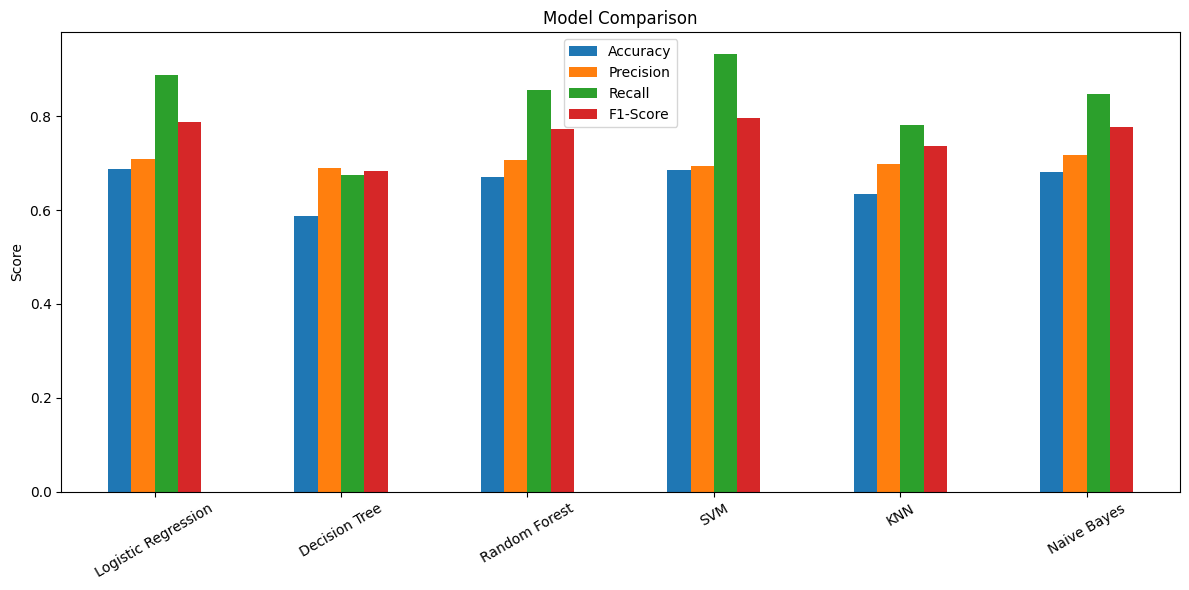

In [9]:
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Comparison')
plt.ylabel('Score')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## 10. Confusion Matrix Analysis


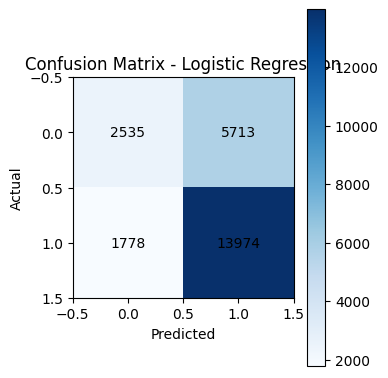

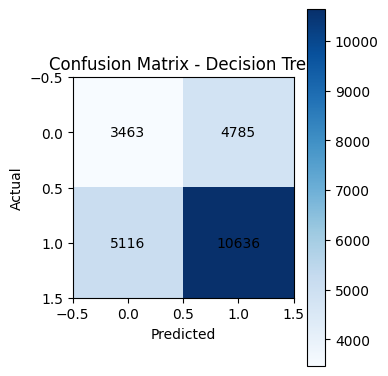

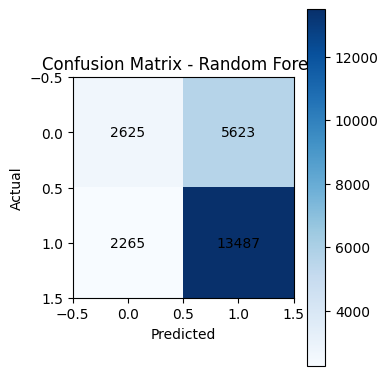

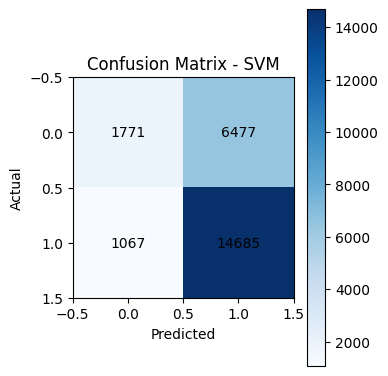

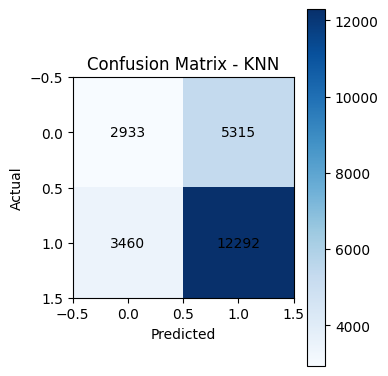

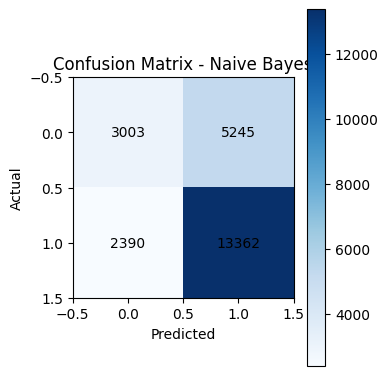

In [10]:
for model in results:
    cm = results[model]['Confusion Matrix']
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, cmap='Blues')
    plt.title(f'Confusion Matrix - {model}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center')
    plt.colorbar()
    plt.tight_layout()
    plt.show()


## 11. Cross-Validation (Model Stability)


In [11]:
rf_cv = RandomForestClassifier(n_estimators=200, random_state=42)
cv_scores = cross_val_score(rf_cv, X, y, cv=5, scoring='f1')

print('Cross-Validation Scores:', cv_scores)
print('Mean Score:', cv_scores.mean())


Cross-Validation Scores: [0.77544816 0.77451232 0.77554765 0.7758185  0.77826062]
Mean Score: 0.7759174503597333


## 12. ROC-AUC Curve


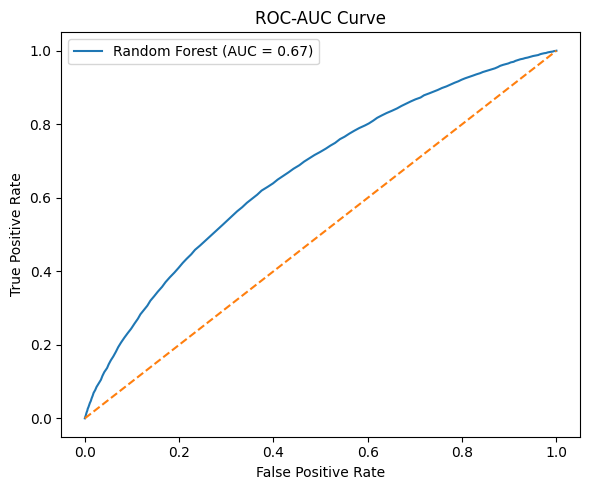

In [12]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

y_prob = rf_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.tight_layout()
plt.show()


## 13. Final Model Training & Saving


In [13]:
final_model = RandomForestClassifier(n_estimators=200, random_state=42)
final_model.fit(X_train, y_train)

# Save production artifacts
joblib.dump(final_model, models_dir / 'cardio_random_forest_model.pkl')
joblib.dump(final_model, models_dir / 'cardio_model.pkl')
joblib.dump(scaler, models_dir / 'cardio_scaler.pkl')

report = {
    'timestamp': datetime.utcnow().isoformat(timespec='seconds') + 'Z',
    'dataset': 'cardio.csv',
    'shape': list(data.shape),
    'target_distribution': y.value_counts().to_dict(),
    'metrics': metrics_df.to_dict(orient='index'),
    'cv_scores': cv_scores.tolist(),
    'cv_mean': float(cv_scores.mean()),
    'roc_auc': float(auc),
    'selected_model': 'Random Forest'
}

report_file = 'cardio_training_report.json' if 'cardio' == 'cardio' else 'latest_training_report.json'
(reports_dir / report_file).write_text(json.dumps(report, indent=2), encoding='utf-8')

print('Cardiovascular Risk Prediction Model artifacts saved successfully.')


Cardiovascular Risk Prediction Model artifacts saved successfully.


## 14. Conclusion

- Comparative evaluation completed across six supervised models
- Cross-validation confirms stability
- ROC-AUC indicates separability quality
- Selected model saved and ready for Flask deployment
